In [1]:
%matplotlib inline

import os
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pyspark
import pyspark.sql.functions as sparkfunc

matplotlib.rcParams['figure.dpi'] = 120

from dustmaps.sfd import SFDQuery

from gaia_tools import healpix_hist, bin_column
from numpy import pi
from pyspark.sql import SparkSession


In [2]:
#spark = SparkSession.builder.config('spark.master', "local[4]") \
#                            .config('spark.memory.offHeap.enabled', 'true') \
#                            .config('spark.memory.offHeap.size', '6G') \
#                            .config('spark.driver.memory', '8G') \
#                            .config("spark.sql.execution.arrow.enabled", "true").getOrCreate()

In [2]:
def spark_start(project_path, metastore=None):
    from pyspark.sql import SparkSession

    warehouse_location = os.path.join(project_path, 'spark-warehouse')

    local_dir = os.path.join(project_path, 'spark-tmp')

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[4]")
            .config('spark.driver.memory', '6G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

In [3]:
root_dir = "/epyc/users/ctslater"

spark = spark_start(root_dir)

In [4]:
#gaia_ = spark.read.load("/epyc/data/gaia_dr2_1am_dup/")
gaia_ = spark.read.table('gaia_dr2_1am_dup')
gaia = gaia_.drop("hpix12").withColumn("hpix12",
                        sparkfunc.floor(gaia_['source_id']/34359738368))

In [26]:
%%time

sfd_order = 9
sfd = SFDQuery()
npix = hp.nside2npix(hp.order2nside(sfd_order))

angle_theta, angle_phi = hp.pix2ang(hp.order2nside(sfd_order), np.arange(npix), nest=True)

EBV_map_hpix9 = sfd.query_equ(np.rad2deg(angle_phi), 90.0 - np.rad2deg(angle_theta))

# This is not necessary; much faster to join the Gaia data at hpix9 resolution
# than to upgrade the resolution of the SFD map.
#
#EBV_map_hpix12 = hp.ud_grade(reddening, hp.order2nside(12), order_in='NEST')

pandas_df = pd.DataFrame({"hpix9": np.arange(len(EBV_map_hpix9)),
                                             "EBV": EBV_map_hpix9})

reddening_df = spark.createDataFrame(pandas_df)
gaia_w_EBV = gaia.join(reddening_df, reddening_df.hpix9 == sparkfunc.floor(gaia.hpix12/4**3))

gaia_g0 = gaia_w_EBV.withColumn("phot_g0", gaia_w_EBV['phot_g_mean_mag'] - 3.1*gaia_w_EBV['EBV']).\
                      withColumn("bp_rp_0", gaia_w_EBV['bp_rp'] - 1.2919*gaia_w_EBV['EBV'])

CPU times: user 5.51 s, sys: 850 ms, total: 6.36 s
Wall time: 3.41 s


In [27]:
%%time

# Diagnostic for the dereddening join
if False:
    dereddened_density2 = healpix_hist(gaia_g0. \
                                      where((gaia_g0['dup'] == 0) &
                                            (gaia_g0['bp_rp_0'] > 0.5) & (gaia_g0['bp_rp_0'] < 0.75) &
                                            (gaia_g0['phot_g0'] > 19) & (gaia_g0['phot_g0'] <= 20.5) &
                                            (gaia_g0['parallax'] < 0.2)),
                                       NSIDE=512, agg={"hpix__": "count"})

CPU times: user 219 ms, sys: 41.5 ms, total: 261 ms
Wall time: 6min 46s


In [7]:
def spark_mu_l(alpha, delta, mu_ra, mu_dec):
    from pyspark.sql.functions import sin, cos, sqrt
    alpha_g =  192.85948 * pi/180.0
    delta_g = 27.12825 * pi/180.0
    C1 = np.sin(delta_g) * cos(delta) - np.cos(delta_g) * sin(delta) * cos(alpha - alpha_g)
    C2 = np.cos(delta_g)* sin(alpha - alpha_g)
    cosb = sqrt(C1**2 + C2**2)    
    return (mu_ra * C1 + mu_dec * C2)/cosb

def spark_mu_b(alpha, delta, mu_ra, mu_dec):
    from pyspark.sql.functions import sin, cos, sqrt
    alpha_g =  192.85948 * pi/180.0
    delta_g = 27.12825 * pi/180.0
    C1 = np.sin(delta_g) * cos(delta) - np.cos(delta_g) * sin(delta) * cos(alpha - alpha_g)
    C2 = np.cos(delta_g)* sin(alpha - alpha_g)
    cosb = sqrt(C1**2 + C2**2)
    return (mu_ra * -C2 + mu_dec * C1)/cosb

In [29]:
%%time

def star_cuts(df):
    return ((df['dup'] == 0) &
            (df['bp_rp_0'] > 0.5) & (df['bp_rp_0'] < 0.75) &
            (df['phot_g0'] > 19) &  (df['phot_g0'] <= 20.5) &
            (df['parallax'] < 0.2))

def add_mu_b(df):
    return df.withColumn("mu_b", spark_mu_b(df['ra']*pi/180.0, df['dec']*pi/180.0,
                                            df['pmra'], df['pmdec']))

gaia_g0_mu_b = add_mu_b(gaia_g0.where(star_cuts(gaia_g0)))
            
map_negative_b = healpix_hist(gaia_g0_mu_b.where(gaia_g0_mu_b['mu_b'] < 0),
                              NSIDE=512, agg={"hpix__": "count"})



CPU times: user 212 ms, sys: 24.8 ms, total: 237 ms
Wall time: 7min 42s


In [31]:
%%time
map_pos_b = healpix_hist(gaia_g0_mu_b.where(gaia_g0_mu_b['mu_b'] >= 0),
                         NSIDE=512, agg={"hpix__": "count"})

CPU times: user 187 ms, sys: 31.2 ms, total: 218 ms
Wall time: 7min 17s


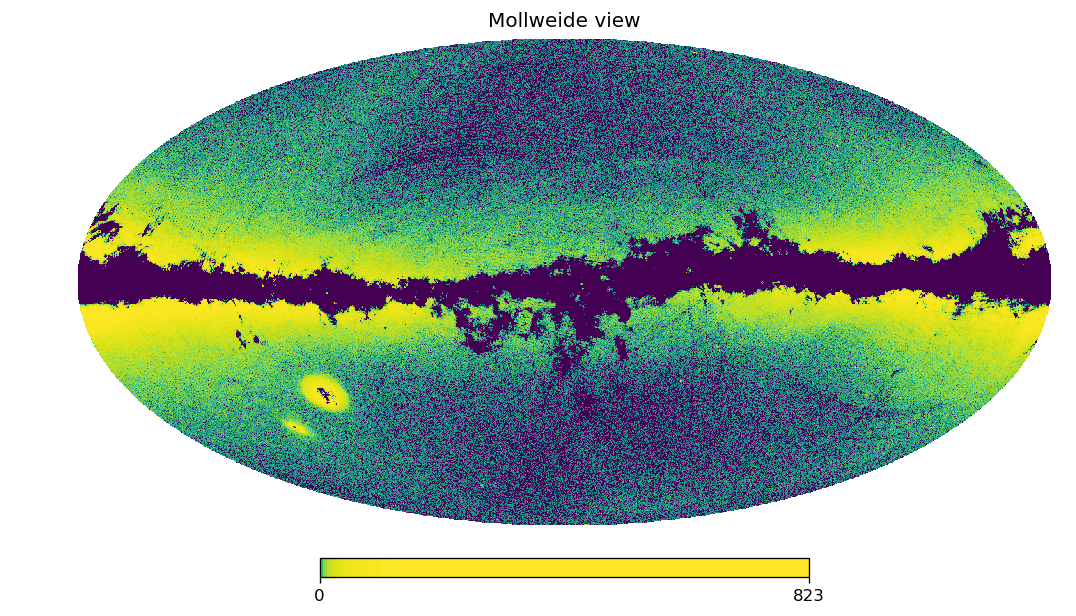

In [28]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(dereddened_density2, rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')

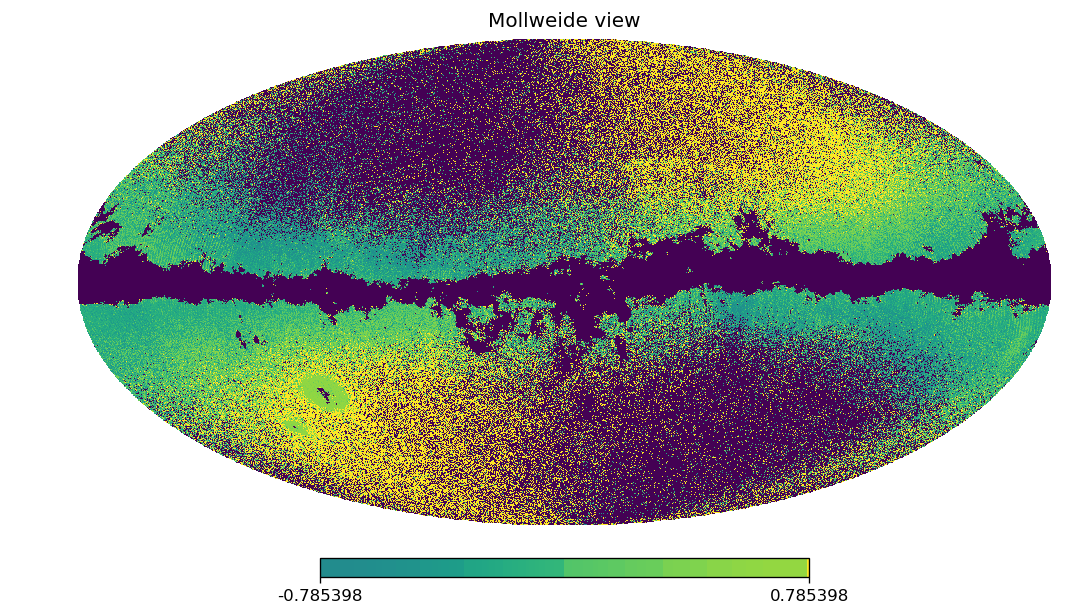

In [37]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(np.arctan2(map_pos_b, map_negative_b) - np.arctan(1), rot=(266.4 - 180, 28.94, -57),
            xsize=1400,  #min=0.1, max=2.0,
            nest=True, norm='hist')